In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [156]:
df1 = pd.read_csv("prices_round_3_day_0.csv", sep = ';' )
df2 = pd.read_csv("prices_round_3_day_1.csv", sep = ';' )
df3 = pd.read_csv("prices_round_3_day_2.csv", sep = ';')
df = pd.concat([df1, df2, df3], ignore_index=True)

In [157]:
df = df.sort_values(['day', 'timestamp']).reset_index(drop=True)

# --- Compute cumulative offsets for each day ---
# For each day, the offset is the cumulative sum of (max timestamp + 1) for all earlier days.
offset = 0
offsets = {}
# Sort the unique days in ascending order so that earlier days come first.
for d in sorted(df['day'].unique()):
    offsets[d] = offset
    # Assume each day’s timestamp starts at 0, so the total length is max(timestamp) + 1.
    max_ts = df.loc[df['day'] == d, 'timestamp'].max()
    offset += max_ts + 1

# --- Create an absolute timestamp ---
# Map each row’s day to its offset and then add the intra-day timestamp.
df['abs_timestamp'] = df['timestamp'] + df['day'].map(offsets)

# --- Set the absolute timestamp as the index ---
df = df.set_index('abs_timestamp')

In [158]:
#prices = df.drop(columns = [", "timestamp"])
prices = df.copy(deep = True)
prices = prices.rename_axis("time")

In [159]:
prices['TTE'] = 8-(prices['day'] + prices['timestamp']/1000000)

In [160]:
voucher_cols = ['VOLCANIC_ROCK','VOLCANIC_ROCK_VOUCHER_9500','VOLCANIC_ROCK_VOUCHER_9750','VOLCANIC_ROCK_VOUCHER_10000','VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500']
vouchers = {}
for i, voucher in enumerate(voucher_cols):
    vouchers[f'v{i}'] = prices[prices['product'] == voucher]
    if(voucher != "VOLCANIC_ROCK"):
        vouchers[f'v{i}']['K'] = int(voucher.split('_')[-1])
        vouchers[f'v{i}']['St'] = vouchers['v0']['mid_price']

C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2560988516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[f'v{i}']['K'] = int(voucher.split('_')[-1])
C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2560988516.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[f'v{i}']['St'] = vouchers['v0']['mid_price']
C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2560988516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [161]:
for i in range(1,6):
    v = f'v{i}'
    
    vouchers[v]['m_t'] = np.log(vouchers[v]['K']/vouchers[v]['St'])/np.sqrt(vouchers[v]['TTE'])
    

C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2705966189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[v]['m_t'] = np.log(vouchers[v]['K']/vouchers[v]['St'])/np.sqrt(vouchers[v]['TTE'])
C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2705966189.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[v]['m_t'] = np.log(vouchers[v]['K']/vouchers[v]['St'])/np.sqrt(vouchers[v]['TTE'])
C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2705966189.py:4: SettingWithCopyWarning: 
A value

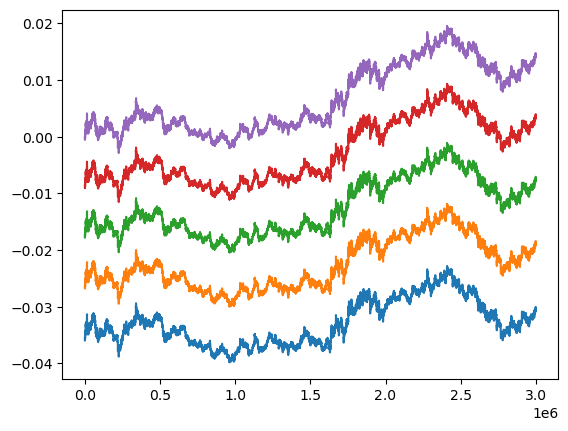

In [162]:
plt.plot(vouchers['v1']['m_t'])
plt.plot(vouchers['v2']['m_t'])
plt.plot(vouchers['v3']['m_t'])
plt.plot(vouchers['v4']['m_t'])
plt.plot(vouchers['v5']['m_t'])

In [163]:
import pandas as pd
from scipy.stats import norm
from scipy.optimize import brentq
import numpy as np

def black_scholes(S, K, T, sigma):

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return price

def implied_volatility(price, S, K, T):
    T = T/365
    def objective_function(sigma):
        return black_scholes(S, K, T, sigma) - price
    try:
        implied_vol = brentq(objective_function, 0.00001, .02)
        return implied_vol
    except ValueError:
          return np.nan

In [164]:
for j in range(1,6):
    voucher = f'v{j}'
    implied_vols = []
    for i in range(len(vouchers[voucher])):
        row = vouchers[voucher].iloc[i]

        price = row.loc['mid_price']
        strike = row.loc['K']
        spot = row.loc['St']
        T = row.loc['TTE']
        implied_vols.append(implied_volatility(price, spot, strike, T))
        if(i%500 == 0):
            print(i)
    vouchers[voucher]['IV'] = implied_vols

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500


C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2118955977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[voucher]['IV'] = implied_vols


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500


C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2118955977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[voucher]['IV'] = implied_vols


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500


C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2118955977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[voucher]['IV'] = implied_vols


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500


C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2118955977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[voucher]['IV'] = implied_vols


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500


C:\Users\tzs7ch\AppData\Local\Temp\ipykernel_15428\2118955977.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vouchers[voucher]['IV'] = implied_vols


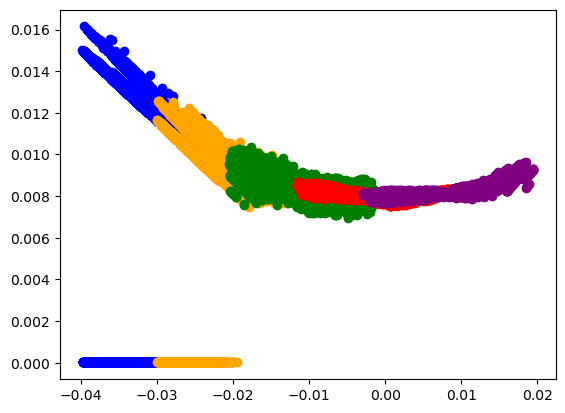

In [169]:
plt.scatter(vouchers['v1']['m_t'], vouchers['v1']['IV'], color = 'b')
plt.scatter(vouchers['v2']['m_t'], vouchers['v2']['IV'], color = 'orange')
plt.scatter(vouchers['v3']['m_t'], vouchers['v3']['IV'], color = 'g')
plt.scatter(vouchers['v4']['m_t'], vouchers['v4']['IV'], color = 'r')
plt.scatter(vouchers['v5']['m_t'], vouchers['v5']['IV'], color = 'purple')


In [187]:
vi_df = pd.concat([vouchers['v1'],
                      vouchers['v2'],
                      vouchers['v3'],
                      vouchers['v4'],
                      vouchers['v5']])

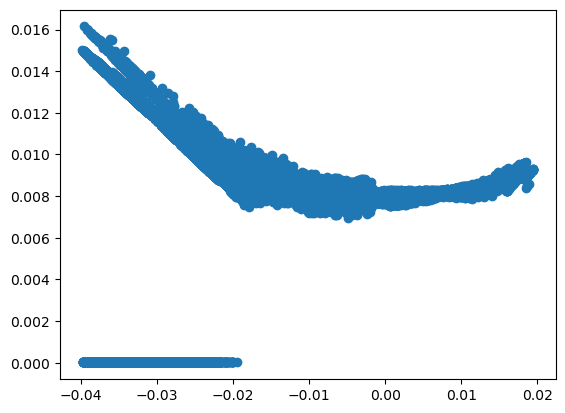

In [190]:
plt.scatter(vi_df['m_t'], vi_df['IV'])